In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd "/content/gdrive/My Drive/UCCD3074_Labs/Face_Recognition"

/content/gdrive/My Drive/UCCD3074_Labs/Face_Recognition


In [ ]:
############################ 
#Coded by Gan Kian Yu 
############################

In [ ]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset
from torch.optim import lr_scheduler

import random
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import copy

In [ ]:
print(torch.__version__) #import when we need to load model

1.12.1+cu113


# Class FaceDataset

In [ ]:
class FaceDataset(Dataset):

    def __init__(self, root, transform=None):
      self.data = [] #'name0_0001.jpg', 'name0_0002.jpg', ... #save path but not image, because save memory
      self.label = [] #0, 1, 2 ... 
      self.classes = os.listdir(root) #get the list of classes in the directory ['name0', 'name1', ...]
      self.transform = transform

      #get the list of all files in the dataset (load file name)
      for l, c in enumerate(self.classes): #'name0', 'name1' ...
        cls_folder = os.path.join(root, c)
        for f in os.listdir(cls_folder): #'name0_0001.jpg', 'name0_0002.jpg', ...
          self.data.append(os.path.join(cls_folder, f))
          self.label.append(l)
      self.np_label = np.array(self.label)

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      """return 3 images each batch (Anchor, positive, negative) """
      #get indexs range that having same class with anchor image
      same_c_idx = np.where(self.np_label == self.label[idx])[0]
      min_same_c_idx = np.min(same_c_idx)
      max_same_c_idx = np.max(same_c_idx)

      #random generate index for positive image (same class with anchor)
      idx2 = random.randint(min_same_c_idx, max_same_c_idx)
      while(idx == idx2): #while index positive is equal to anchor index, random again
        idx2 = random.randint(min_same_c_idx, max_same_c_idx)

      #random generate index for negative image (different class with anchor)
      length = len(self.data)
      idx3 = random.randint(0, length-1)
      while(min_same_c_idx <= idx3 and idx3 <= max_same_c_idx): #while index generated is same class with anchor image
        idx3 = random.randint(0, length-1)
      
      # get the anchore image 
      img_path = self.data[idx]
      anchor = Image.open(img_path) #PIL image
      # get the positive image
      img_path = self.data[idx2]
      pos = Image.open(img_path) #PIL image
      # get the negative image 
      img_path = self.data[idx3]
      neg = Image.open(img_path) #PIL image

      # perform transformation
      if self.transform is not None:
        anchor = self.transform(anchor)
        pos = self.transform(pos)
        neg = self.transform(neg)

      return anchor, pos, neg

---
# Transformation and Data Loader

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# transformer
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
batch_size = 64 #large batch size is recommended to choose semi-hard sample for triplet loss
trainset = FaceDataset("./dataset/train", transform=train_transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
valset = FaceDataset("./dataset/valid", transform=val_transform)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
"""check dimension"""
for i, (anchor, pos, neg) in enumerate(trainloader):
    print("batch:", i)
    print(anchor.shape) #shape = [B, C, H, W]
    print(pos.shape) 
    print(neg.shape) 
    break

batch: 0
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])


row 1: anchor images
row 2: positive images
row 3: negative images


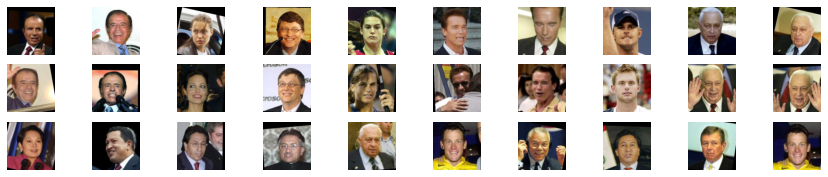

In [ ]:
"""check image loaded"""
anchor_images = []
positive_images = []
negative_images = []
for i in range(0,200,20):
  img, img2, img3 = trainset[i]
  img = img.permute(1, 2, 0)*0.5+0.5 #unnormalize
  img2 = img2.permute(1, 2, 0)*0.5+0.5
  img3 = img3.permute(1, 2, 0)*0.5+0.5
  
  anchor_images.append(img)
  positive_images.append(img2)
  negative_images.append(img3)

fig = plt.figure(figsize=(15, 3))
columns = 10
rows = 3

for i in range(1, columns +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(anchor_images[i-1])
    plt.axis("off")
    fig.add_subplot(rows, columns, i+10)
    plt.imshow(positive_images[i-1])
    plt.axis("off")
    fig.add_subplot(rows, columns, i+20)
    plt.imshow(negative_images[i-1])
    plt.axis("off")

print("row 1: anchor images")
print("row 2: positive images")
print("row 3: negative images")

---
# Customize pretrained model (ResNet-34)

In [ ]:
def customize_network(weights = 'IMAGENET1K_V1'):
    resNet = models.resnet34(weights=weights) 

    # replace the fc layer
    in_c = resNet.fc.in_features  #original: in_features=512, out_features=1000
    resNet.fc = nn.Sequential(
        nn.Linear(in_c, 128),
        nn.ReLU(),
        #nn.Dropout(p=0.5),
        nn.Linear(128, 128), #out_channel = 128 D features for 1 image
        ) 

    return resNet

In [ ]:
resNet = customize_network(weights = 'IMAGENET1K_V1') #loading customized model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
for name, layer in resNet.named_children():
  print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
print(resNet.fc) #check output layer

Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
)


In [ ]:
for name, param in resNet.named_parameters(): #check freezed layers
  print(name, "==>", param.requires_grad)

conv1.weight ==> True
bn1.weight ==> True
bn1.bias ==> True
layer1.0.conv1.weight ==> True
layer1.0.bn1.weight ==> True
layer1.0.bn1.bias ==> True
layer1.0.conv2.weight ==> True
layer1.0.bn2.weight ==> True
layer1.0.bn2.bias ==> True
layer1.1.conv1.weight ==> True
layer1.1.bn1.weight ==> True
layer1.1.bn1.bias ==> True
layer1.1.conv2.weight ==> True
layer1.1.bn2.weight ==> True
layer1.1.bn2.bias ==> True
layer1.2.conv1.weight ==> True
layer1.2.bn1.weight ==> True
layer1.2.bn1.bias ==> True
layer1.2.conv2.weight ==> True
layer1.2.bn2.weight ==> True
layer1.2.bn2.bias ==> True
layer2.0.conv1.weight ==> True
layer2.0.bn1.weight ==> True
layer2.0.bn1.bias ==> True
layer2.0.conv2.weight ==> True
layer2.0.bn2.weight ==> True
layer2.0.bn2.bias ==> True
layer2.0.downsample.0.weight ==> True
layer2.0.downsample.1.weight ==> True
layer2.0.downsample.1.bias ==> True
layer2.1.conv1.weight ==> True
layer2.1.bn1.weight ==> True
layer2.1.bn1.bias ==> True
layer2.1.conv2.weight ==> True
layer2.1.bn2.w

---
# Define triplet loss function

In [ ]:
def triplet_loss(anchor, positive, negative, margin=1.0, difficulty='hard', reduction ='mean', eps = 1e-10):
  d_AP = torch.square(anchor - positive).sum(axis=1)
  d_AP = torch.sqrt(d_AP)

  d_AN = torch.square(anchor - negative).sum(axis=1)
  d_AN = torch.sqrt(d_AN)

  pairwise_distance = d_AP + margin - d_AN 
  loss = torch.where(pairwise_distance>0, pairwise_distance, 0)

  if reduction == 'none':
      return loss
      
  if torch.count_nonzero(loss)==0: 
      cost = torch.mean(loss + eps)
  else:
      if difficulty == 'hard':
          cost = torch.mean(loss[loss!=0]) #ignore triplets that has 0 loss, to avoid them to pull down the mean loss value 
      else:
          cost = torch.mean(loss)

  return cost

In [ ]:
"""testing triplet loss function """
anchor = torch.tensor([[2, 2, 2], [2, 2, 2]])
positive = torch.tensor([[1, 1, 1], [1, 1, 1]])
negative = torch.tensor([[2, 2, 2], [-2, -2, -2]])

#my loss function
loss = triplet_loss(anchor, positive, negative, reduction ='none')
print("loss i calculate:", loss)
cost = triplet_loss(anchor, positive, negative, reduction ='mean')
print("cost i calculate:", cost)
cost = triplet_loss(anchor, positive, negative, difficulty='easy', reduction ='mean')
print("cost i calculate:", cost)

#torch.nn function
triplet_margin_loss = nn.TripletMarginLoss(margin=1.0, p=2, reduction ='none')
loss = triplet_margin_loss(anchor, positive, negative)
print('loss torch: ', loss)

triplet_margin_loss = nn.TripletMarginLoss(margin=1.0, p=2)
cost = triplet_margin_loss(anchor, positive, negative)
print('cost torch: ', cost)

loss i calculate: tensor([2.7321, 0.0000])
cost i calculate: tensor(2.7321)
cost i calculate: tensor(1.3660)
loss torch:  tensor([2.7321, 0.0000])
cost torch:  tensor(1.3660)


---
# Finetune / Train model

In [ ]:
def finetune(model, trainloader, valloader, lr_toTune=[0.01], num_epochs=20, difficulty=None): 
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    
    model = model.to(device) #transfer model to device available
    initial_model_wts = copy.deepcopy(model.state_dict()) #store initial model weight
    weights = [] #used to store different model's weight
    lowest_loss = []
    total_train_history = [] #used to store different model's train loss every epoch , shape=(total_model, total_loss)
    total_val_history = [] #used to store different model's val loss every epoch
    
    for model_num, lr in enumerate(lr_toTune):
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) #set initial lr to lr that need to tune
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        train_history = []  #store train loss for a model in each epoch
        val_history = []  #store val loss for a model in each epoch
        lowest_val_loss = 100. #used to compare to get best model weight
        best_model_wts = copy.deepcopy(model.state_dict())
        
        for e in range(num_epochs):    # epoch iteration
            running_train_loss = 0.
            running_count = 0.
            running_val_loss = 0. 
            running_count_val = 0.
            #-------------------train-------------
            model.train() # set model to training mode
            for i, (anchor, pos, neg) in enumerate(trainloader):  #batch iteration 
                print(".",end="")
                # Clear all the gradient to 0
                optimizer.zero_grad()

                # transfer data to device available
                anchor = anchor.to(device)
                pos = pos.to(device)
                neg = neg.to(device)

                # forward propagation
                outs_anchor = model(anchor)
                outs_pos = model(pos)
                outs_neg = model(neg)

                # compute triplet loss
                if difficulty is None: #by default, use hard sample to train model
                    loss = triplet_loss(outs_anchor, outs_pos, outs_neg)
                else:
                    if difficulty[model_num] == 'easy':
                        loss = triplet_loss(outs_anchor, outs_pos, outs_neg, difficulty='easy') #taking all sample' loss (include loss 0)to compute mean loss
                    else:
                        loss = triplet_loss(outs_anchor, outs_pos, outs_neg) #taking only hard's sample (not include loss 0) to compute mean loss

                # backpropagation to get dw
                loss.backward()

                # update the parameters
                optimizer.step()

                # get the loss
                running_train_loss += loss.item()
                running_count += 1
            # compute the averaged train loss in each epoch
            train_loss = running_train_loss / running_count
            train_history.append(train_loss)
            # Update the scheduler's counter at the end of each epoch
            scheduler.step() #step +1
            #-------------val------------------
            model.eval()
            for i, (anchor, pos, neg) in enumerate(valloader):  #batch iteration
                # transfer data to device available
                anchor = anchor.to(device)
                pos = pos.to(device)
                neg = neg.to(device)

                with torch.no_grad():
                    # forward propagation
                    outs_anchor = model(anchor)
                    outs_pos = model(pos)
                    outs_neg = model(neg)

                    # compute triplet loss (in validation, we select easy triplets to calculate loss to show how well is the current feature extractor for all sample)
                    loss_val = triplet_loss(outs_anchor, outs_pos, outs_neg, difficulty='easy')

                    # get the loss
                    running_val_loss += loss_val.item()
                    running_count_val += 1
            # compute the averaged val loss in each epoch
            val_loss = running_val_loss / running_count_val
            val_history.append(val_loss)
            print(f'Model {model_num} (lr={lr}), Epoch {e+1:2d}/{num_epochs:d} : train_loss = {train_loss:.4f}, val_loss = {val_loss:.4f}') 
            if val_loss <= lowest_val_loss:
                lowest_val_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        #after training a model
        weights.append(best_model_wts) #store model's best weight
        total_train_history.append(train_history)
        total_val_history.append(val_history)    
        model.load_state_dict(initial_model_wts) #reset model to initial weight, to finetune another hyperparameter
        print("model's weight reset")
    return weights, total_train_history, total_val_history

In [ ]:
def plotFineTunedGraph(total_train_history, total_val_history, lr_toTune, showTrainLoss=True, showValLoss=True, ignoreNum=None, difficulty=None): #ignoreNum can be [0, 2] to hide model 0 and model 2
    colors = ['b','g','r','c'] #blue, green, red, cyan

    for num_model, lr in enumerate(lr_toTune): #iterate all model, num_lr_toTune = num_model.
        #if the model is not interested to show, skip it
        if ignoreNum is not None:
            if num_model in ignoreNum:
                continue
        
        #-------------plot graph-----------------------
        epochs = range(1, len(total_train_history[0])+1) 
        if showTrainLoss == True:
          plt.plot(epochs, total_train_history[num_model], color=colors[num_model], label='Train loss model ' + str(num_model))
        if showValLoss == True:
          plt.plot(epochs, total_val_history[num_model], color=colors[num_model], linestyle='dashed', label='  Val loss model '+str(num_model))

        #------------print models detail---------------------------
        if difficulty is None:
            print(f'Model {num_model} (lr={lr})')
        else:
            print(f'Model {num_model} (lr={lr}, train with {difficulty[num_model]} sample)')
            
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
"""finetuning 4 model"""
lr_toTune=[0.0025, 0.001, 0.0005, 0.0005] 
difficulty = ['hard', 'hard', 'hard', 'easy'] #model 0 use easy triplets to train, model 1 use semi-hard sample to train
epochs=20
resNet = customize_network(weights = 'IMAGENET1K_V1') #loading customized model
weights, total_train_history, total_val_history = finetune(resNet, trainloader, valloader, lr_toTune=lr_toTune, num_epochs=epochs, difficulty=difficulty) 

.................................Model 0 (lr=0.0025), Epoch  1/20 : train_loss = 0.8030, val_loss = 0.3614
.................................Model 0 (lr=0.0025), Epoch  2/20 : train_loss = 0.9915, val_loss = 0.2606
.................................Model 0 (lr=0.0025), Epoch  3/20 : train_loss = 1.3229, val_loss = 0.2811
.................................Model 0 (lr=0.0025), Epoch  4/20 : train_loss = 1.2608, val_loss = 0.2927
.................................Model 0 (lr=0.0025), Epoch  5/20 : train_loss = 1.2872, val_loss = 0.3135
.................................Model 0 (lr=0.0025), Epoch  6/20 : train_loss = 1.1039, val_loss = 0.2312
.................................Model 0 (lr=0.0025), Epoch  7/20 : train_loss = 1.1879, val_loss = 0.3082
.................................Model 0 (lr=0.0025), Epoch  8/20 : train_loss = 1.3794, val_loss = 0.3425
.................................Model 0 (lr=0.0025), Epoch  9/20 : train_loss = 1.2001, val_loss = 0.2997
.................................Mode

Model 2 (lr=0.0005, train with hard sample)
Model 3 (lr=0.0005, train with easy sample)


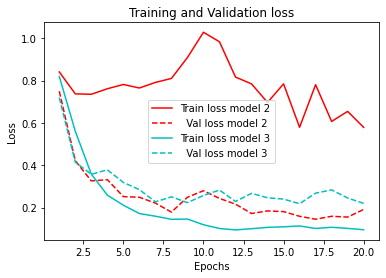

In [ ]:
#show difference between model trained with semi-hard triplets and model trained with easy triplets
plotFineTunedGraph(total_train_history, total_val_history, lr_toTune=lr_toTune, difficulty=difficulty, ignoreNum=[0, 1])

Model 0 (lr=0.0025, train with hard sample)
Model 1 (lr=0.001, train with hard sample)
Model 2 (lr=0.0005, train with hard sample)


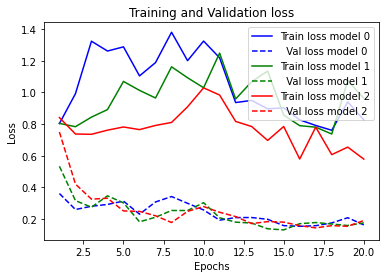

In [ ]:
#show difference between different learning rate
plotFineTunedGraph(total_train_history, total_val_history, lr_toTune=lr_toTune, difficulty=difficulty, ignoreNum=[3])

In [ ]:
#train model 
lr_toTune=[0.001] 
epochs=100
resNet = customize_network(weights = 'IMAGENET1K_V1') #loading customized model
weights, total_train_history, total_val_history = finetune(resNet, trainloader, valloader, lr_toTune=lr_toTune, num_epochs=epochs) 

.................................Model 0 (lr=0.001), Epoch  1/100 : train_loss = 0.8112, val_loss = 0.4751
.................................Model 0 (lr=0.001), Epoch  2/100 : train_loss = 0.7869, val_loss = 0.2965
.................................Model 0 (lr=0.001), Epoch  3/100 : train_loss = 0.8351, val_loss = 0.2631
.................................Model 0 (lr=0.001), Epoch  4/100 : train_loss = 0.9755, val_loss = 0.3087
.................................Model 0 (lr=0.001), Epoch  5/100 : train_loss = 1.0210, val_loss = 0.2439
.................................Model 0 (lr=0.001), Epoch  6/100 : train_loss = 0.9337, val_loss = 0.2917
.................................Model 0 (lr=0.001), Epoch  7/100 : train_loss = 1.1789, val_loss = 0.2809
.................................Model 0 (lr=0.001), Epoch  8/100 : train_loss = 1.0356, val_loss = 0.2441
.................................Model 0 (lr=0.001), Epoch  9/100 : train_loss = 1.2549, val_loss = 0.2979
.................................Mode

Model 0 (lr=0.001)


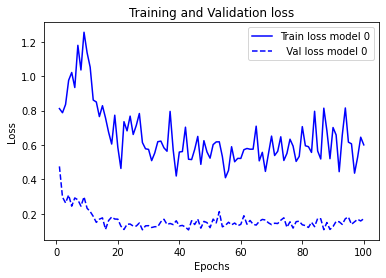

In [ ]:
plotFineTunedGraph(total_train_history, total_val_history, lr_toTune=lr_toTune)

In [ ]:
Best_resNet = customize_network(weights = 'IMAGENET1K_V1')
Best_resNet.load_state_dict(weights[0]) #load best trained weight
torch.save(Best_resNet, "saved_best_resNet34.pt") #save whole model

---
# Test model

In [ ]:
my_resNet = torch.load("saved_best_resNet34.pt") #load model

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_set = FaceDataset("./dataset/test", transform=test_transform)
testloader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=0)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = my_resNet.to(device) #transfer model to device available
running_test_loss = 0.
running_count_test = 0.
for i, (anchor, pos, neg) in enumerate(testloader):  #batch iteration
    # transfer data to device available
    if torch.cuda.is_available():
        anchor = anchor.cuda()
        pos = pos.cuda()
        neg = neg.cuda()

    with torch.no_grad():
        # forward propagation
        outs_anchor = my_resNet(anchor)
        outs_pos = my_resNet(pos)
        outs_neg = my_resNet(neg)

        # compute triplet loss (in testing, we select easy triplets to calculate loss to show how well is the current feature extractor for all sample)
        loss_val = triplet_loss(outs_anchor, outs_pos, outs_neg, difficulty='easy')

        # get the loss
        running_test_loss += loss_val.item()
        running_count_test += 1
# compute the averaged test loss in each epoch
test_loss = running_test_loss / running_count_test

In [ ]:
print("Testing loss:", test_loss)

Testing loss: 0.18797574072114884
